# Figure for Chauve et al. 202X

In [1]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as sts
import matplotlib.patches as mp
import matplotlib.cm as cm
import matplotlib
import scipy
import xarray as xr
import xarrayaita.loadData_aita as lda
import xarray_symTensor2d.xarray_symTensor2d as sT
import xarrayuvecs.uvecs as xu
import os
from tqdm import trange

import lib_cti.lib_cti_uvec_meshio as lcum

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 18
})

In [2]:
def cut_z(c_axis,res_ech=180,nb_r=1000):
    phi=np.zeros(res_ech)
    theta=np.linspace(0,np.pi,res_ech)

    theta_r=2.*np.pi*np.random.rand(nb_r)
    phi_r=np.arccos(np.random.rand(nb_r))

    res_v=np.zeros([len(c_axis.time),180])

    for i in trange(len(c_axis.time)):
        kde=c_axis[i,...].uvecs.calcODF()
        res=kde.score_samples(np.transpose(np.array([phi,theta])))
        res_r=kde.score_samples(np.transpose(np.array([phi_r,theta_r])))

        res_v[i,:]=np.exp(res)/np.nanmean(np.exp(res_r))

        ds=xr.DataArray(np.transpose(res_v),dims=[r'$\theta$','iter'])
        ds[r'$\theta$']=(theta-np.pi/2)*180/np.pi

    return ds

def just_ai(path,strain_exp,true_time,adr_aita=np.zeros(1),tension=False,plotEF=True,vmin=np.nan,vmax=np.nan,**kwarg):
    if tension:
        ct=-1
    else:
        ct=1
    ############################
    ###### Load the data #######
    ############################
    current_dir=os.getcwd()
    os.chdir(current_dir+'/'+folder)
    ########## c-axis ##########
    c_axis=lcum.load_vector_P0('c-axis',mod=0)
    ############ c0 ############
    c0=lcum.load_vector_P0('c0',mod=0)
    os.chdir(current_dir)
    ###### open metadata #######
    with open(folder+'/'+'metadata.json', "r") as read_file:
        data = json.load(read_file)
    ###### open time_step ######
    df_macro = pd.read_csv(folder+'time_step.txt',delimiter=';')
    
    ##################################
    ### Compute Enhancement Factor ###
    ##################################
    if data['bc']['top']['type_x'] == "none":
        df_macro['macro_strain']=np.abs(1-np.cumprod(1.+np.array(df_macro[comp])*data['time_step']['dt']))
        if tension:
            coeff=-1*ct
            comp='d22'
            EF=df_macro.d22.max()/df_macro.d22.min()
            p_ef_x = np.where(df_macro.d22==df_macro.d22.max())[0][0]
            p_ef_y=df_macro.d22.min()/true_time
        else:
            coeff=-1*ct
            comp='d22'
            EF=df_macro.d22.min()/df_macro.d22.max()
            #p_ef_x = np.where(df_macro.d22==df_macro.d22.min())[0][0]*data['time_step']['dt']
            p_ef_x = np.where(df_macro.d22==df_macro.d22.min())[0][0]
            p_ef_y=-df_macro.d22.max()/true_time
        
    elif data['bc']['top']['type_x'] == "neumann":
        coeff=1
        comp='d12'
        EF=df_macro.d12.max()/df_macro.d12.min()
        #p_ef_x = np.where(df_macro.d12==df_macro.d12.max())[0][0]*data['time_step']['dt']
        p_ef_x = np.where(df_macro.d12==df_macro.d12.max())[0][0]
        p_ef_y=df_macro.d12.min()/true_time
        df_macro['macro_strain']=np.cumsum(np.array(df_macro[comp])*data['time_step']['dt'])

    # compute true strain rate (s^-1) and true time (h)
    df_macro['macro_strain_rate']=coeff*df_macro[comp]/true_time
    df_macro['true_time_h']=df_macro.time_iter*data['time_step']['dt']*true_time/3600

    eigenvalue=np.zeros([len(c_axis.time),4])
    for i in c_axis.time:
        a,v=c_axis[i,...].uvecs.OT2nd()
        eigenvalue[i,1::]=a

    df_eigenvalue=pd.DataFrame(eigenvalue,columns=['strain','a1', 'a2', 'a3'])

    return df_eigenvalue,df_macro

def summary_simu(path,strain_exp,true_time,adr_aita=np.zeros(1),tension=False,plotEF=True,vmin=np.nan,vmax=np.nan,plt_cm=False,max_strain=None,**kwarg):
    if tension:
        ct=-1
    else:
        ct=1
    ############################
    ###### Load the data #######
    ############################
    current_dir=os.getcwd()
    os.chdir(current_dir+'/'+folder)
    ########## c-axis ##########
    c_axis=lcum.load_vector_P0('c-axis',mod=0)
    ############ c0 ############
    c0=lcum.load_vector_P0('c0',mod=0)
    os.chdir(current_dir)
    ###### open metadata #######
    with open(folder+'/'+'metadata.json', "r") as read_file:
        data = json.load(read_file)
    ###### open time_step ######
    df_macro = pd.read_csv(folder+'time_step.txt',delimiter=';')

    ##################################
    ### Compute Enhancement Factor ###
    ##################################
    if data['bc']['top']['type_x'] == "none":
        comp='d22'
        df_macro['macro_strain']=np.abs(1-np.cumprod(1.+np.array(df_macro[comp])*data['time_step']['dt']))
        #print(df_macro.macro_strain)
        # filtered_df = df[df['x'] < 0.6]
        if max_strain is not None:
            df_macro_tmp=df_macro[df_macro['macro_strain']<max_strain]
        else:
            df_macro_tmp=df_macro
        if tension:
            coeff=-1*ct
            EF=df_macro_tmp.d22.max()/df_macro_tmp.d22.min()
            p_ef_x = np.where(df_macro_tmp.d22==df_macro_tmp.d22.max())[0][0]
            p_ef_y=df_macro_tmp.d22.min()/true_time
        else:
            coeff=-1*ct
            EF=df_macro_tmp.d22.min()/df_macro_tmp.d22.max()
            p_ef_x = np.where(df_macro_tmp.d22==df_macro_tmp.d22.min())[0][0]
            p_ef_y=-df_macro_tmp.d22.max()/true_time
        


    elif data['bc']['top']['type_x'] == "neumann":
        coeff=1
        comp='d12'
        df_macro['macro_strain']=np.cumsum(np.array(df_macro[comp])*data['time_step']['dt'])
        if max_strain is not None:
            df_macro_tmp=df_macro[df_macro['macro_strain']<max_strain]
        else:
            df_macro_tmp=df_macro
        EF=df_macro_tmp.d12.max()/df_macro_tmp.d12.min()
        p_ef_x = np.where(df_macro_tmp.d12==df_macro_tmp.d12.max())[0][0]
        p_ef_y=df_macro_tmp.d12.min()/true_time
        

    # compute true strain rate (s^-1) and true time (h)
    df_macro['macro_strain_rate']=coeff*df_macro[comp]/true_time
    df_macro['true_time_h']=df_macro.time_iter*data['time_step']['dt']*true_time/3600
    ######################################
    ## Extract strain and stress tensor ##
    ######################################
    tensor_P1=xr.Dataset()
    tensor_P1['D']=lcum.load_tensor_P1(folder,'D')
    tensor_P1['S']=lcum.load_tensor_P1(folder,'S')
    tensor_P1['Deq']=tensor_P1['D'].sT.eqVonMises(lognorm=False)
    tensor_P1['Seq']=tensor_P1['S'].sT.eqVonMises(lognorm=False)

    xD = np.linspace(tensor_P1['Deq'].min(), tensor_P1['Deq'].max(),200)
    xS = np.linspace(tensor_P1['Seq'].min(), tensor_P1['Seq'].max(),200)

    ################################
    ########### Figures ############
    ################################

    ################################
    ######### Macro curve ##########
    ################################
    if len(adr_aita)==1:
        fig = plt.figure(figsize=(10, 10), layout="constrained")
        spec = fig.add_gridspec(12, 2, width_ratios=[1, 0.5])
    else:
        fig = plt.figure(figsize=(20/1.5, 10), layout="constrained")
        spec = fig.add_gridspec(12, 3, width_ratios=[1, 0.5, 0.5])
    
    plt.tight_layout()

    cax = fig.add_axes([0.95, 0.3, 0.05, 0.5])  # adjust the position of the colorbar
    ax0 = fig.add_subplot(spec[2:7, 0])

    ax0.semilogy(df_macro['macro_strain'],df_macro['macro_strain_rate'],'k', linewidth=2)
    if plotEF:
        style = "Simple, tail_width=0.5, head_width=15, head_length=25"
        kw = dict(arrowstyle=style, color="k")
        ax0.annotate('$EF='+str(np.round(EF,1))+'$',(df_macro['macro_strain'][p_ef_x],p_ef_y),rotation=90, va='bottom', ha='right')
        a1=mp.FancyArrowPatch((df_macro['macro_strain'][p_ef_x],p_ef_y),(df_macro['macro_strain'][p_ef_x],p_ef_y*EF),**kw)
        ax0.add_patch(a1)

    if data['bc']['top']['type_x'] == "none" and plt_cm:
        df_macro['macro_strain_rate_exp']=df_macro['macro_strain_rate']*(1+coeff*df_macro['macro_strain'])**(3)
        ax0.semilogy(df_macro['macro_strain'],df_macro['macro_strain_rate_exp'],'-b', linewidth=1)
        
        EF2=df_macro['macro_strain_rate_exp'].max()/df_macro['macro_strain_rate'].min()
        p_ef_x2 = np.where(df_macro['macro_strain_rate_exp']==df_macro['macro_strain_rate_exp'].max())[0][0]
        p_ef_y2=df_macro['macro_strain_rate'].min()

        ax0.annotate('$EF='+str(np.round(EF2,1))+'$',(df_macro['macro_strain'][p_ef_x2],p_ef_y2),rotation=90, va='bottom', ha='right',color='blue')
        kw2 = dict(arrowstyle=style, color="b")
        a2=mp.FancyArrowPatch((df_macro['macro_strain'][p_ef_x2],p_ef_y2),(df_macro['macro_strain'][p_ef_x2],p_ef_y2*EF2),**kw2)
        ax0.add_patch(a2)

    ax0.set_ylabel(r'$\textrm{strain rate }s^{-1}$')
    plt.tick_params('x', labelbottom=False)
    
    plt.grid()
    
    ###### calc texture evo ####
    df=cut_z(c_axis)
    df['iter']=np.concatenate([np.array([0]),np.array(df_macro['macro_strain'][df.iter[1::]*data['output']['out_modulo']-1])])
    
    ##### color bar figure #####
    if np.isnan(vmin):
        vmin=df.min()
    if np.isnan(vmax):
        vmax=df.max()
    ######## plot texture evo #########
    ax1= fig.add_subplot(spec[7::, 0], sharex=ax0)
    ff_cbar=df.plot(cmap=cm.gray_r,ax=ax1,add_colorbar=False,vmin=vmin,vmax=vmax)
    ax1.set_xlabel(r'$\textrm{strain}$')
    ax1.set_ylabel(r'$\theta$')
    ax1.set_yticks(ticks=[-90,-45,0,45,90], labels=['$-X$','$-45$','$Y$','$+45$','$+X$'])
    cbar = plt.colorbar(ff_cbar, cax=cax, orientation='vertical')
    cbar.set_label('$Intensity$')

    ######## plot_OTm ##########
    eigenvalue=np.zeros([len(c_axis.time),4])
    for i in c_axis.time:
        a,v=c_axis[i,...].uvecs.OT2nd()
        eigenvalue[i,1::]=a
        
    eigenvalue[:,0]=df.iter
    df_eigenvalue=pd.DataFrame(eigenvalue,columns=['strain','a1', 'a2', 'a3'])
    ax0_b = fig.add_subplot(spec[0:2, 0], sharex=ax0)
    ax0_b.plot(df_eigenvalue.strain,df_eigenvalue.a1)
    ax0_b.plot(df_eigenvalue.strain,df_eigenvalue.a2)
    ax0_b.plot(df_eigenvalue.strain,df_eigenvalue.a3)
    ax0_b.set_ylabel(r'$a_i$')
    ax0_b.tick_params('x', labelbottom=False)
    ax0_b.grid()
    ax0_b.set_ylim([0,1])

    ######### plot texture ############
    # Simulation
    title_odf_sim=['$(i)$','$(ii)$','$(iii)$']
    ax_odf_sim=[]
    caxis_plotted=[]
    for i in range(3):
        ax_odf_sim.append(fig.add_subplot(spec[i*4:i*4+4,1]))
        ax_odf_sim[i].annotate(title_odf_sim[i],(-2**.5,2**.5-0.2), fontsize=18)
        idx=np.argmin(np.array(np.abs(df.iter-strain_exp[i])))
        ax1.vlines(df.iter[idx],-90,90,colors='b',linestyles='dashed')
        ax1.annotate(' '+title_odf_sim[i],(df.iter[idx],79), fontsize=18)
        c_axis[idx,...].uvecs.plotODF(plotOT=False,angle=np.array([0]),ax=ax_odf_sim[i],vmin=vmin,vmax=vmax,cmap=cm.gray_r,plot_cm=False,xoz_plane=True,**kwarg)
        ax_odf_sim[i].hlines(0,-2**0.5,2**0.5,colors='b',linestyles='dashed')
        caxis_plotted.append(c_axis[idx,...])

    ax_odf_sim[i].set_title(r'$\textrm{\textbf{(d)} Simulation}$', loc='center',y=-0.3)

    # Experiment
    if len(adr_aita)==3:
        ax_odf_exp=[]
        for i in range(3):
            ax_odf_exp.append(fig.add_subplot(spec[i*4:i*4+4,2]))
            da=lda.aita5col(adr_aita[i])
            da.aita.filter(75)
            da.orientation.uvecs.plotODF(plotOT=False,angle=np.array([0]),ax=ax_odf_exp[i],vmin=vmin,vmax=vmax,cmap=cm.gray_r,plot_cm=False,xoz_plane=True,**kwarg)
            a,_=da.orientation.uvecs.OT2nd()
            ax0_b.plot(strain_exp[i],a[0],'ob')
        ax_odf_exp[2].set_title(r'$\textrm{\textbf{(e)} Experiment}$', loc='center',y=-0.3)

    if data['bc']['top']['type_x'] == "none":
        ax1.hlines(-45,df.iter.min(),df.iter.max(), linestyles='dashed',colors='w')
        ax1.hlines(45,df.iter.min(),df.iter.max(), linestyles='dashed',colors='w')
    else:
        alpha=0.5*(np.pi/2-np.arctan(df['iter']))*180/np.pi
        ax1.plot(df['iter'],alpha,'--w')

    fig.axes[3].set_title(r'$\textrm{\textbf{(a)}}$', color='k',x=1.05,y=0.7)
    fig.axes[1].set_title(r'$\textrm{\textbf{(b)}}$', color='k',x=1.05,y=0.88)
    fig.axes[2].set_title(r'$\textrm{\textbf{(c)}}$', color='k',x=1.05,y=0.88)

    if max_strain is not None:
        ax1.set_xlim([0,max_strain])
        ax0_b.set_xlim([0,max_strain])
        ax0.set_xlim([0,max_strain])
        #ax2.set_xlim([0,max_strain])

    ax2 = ax0_b.twiny()
    ax2.set_xlim(ax0_b.get_xlim())
    TT=ax2.get_xticks()
    tc=[]
    for i in np.int32(np.interp(TT,df_macro.macro_strain,df_macro.true_time_h)):
        tc.append('$\\mathdefault{'+str(i)+'}$')
    ax2.set_xticklabels(tc)
    ax2.set_xlabel(r'$\textrm{time }(h)$')
    
    return fig,df_eigenvalue,caxis_plotted

## Uniaxial compression

100%|██████████| 68/68 [00:32<00:00,  2.07it/s]


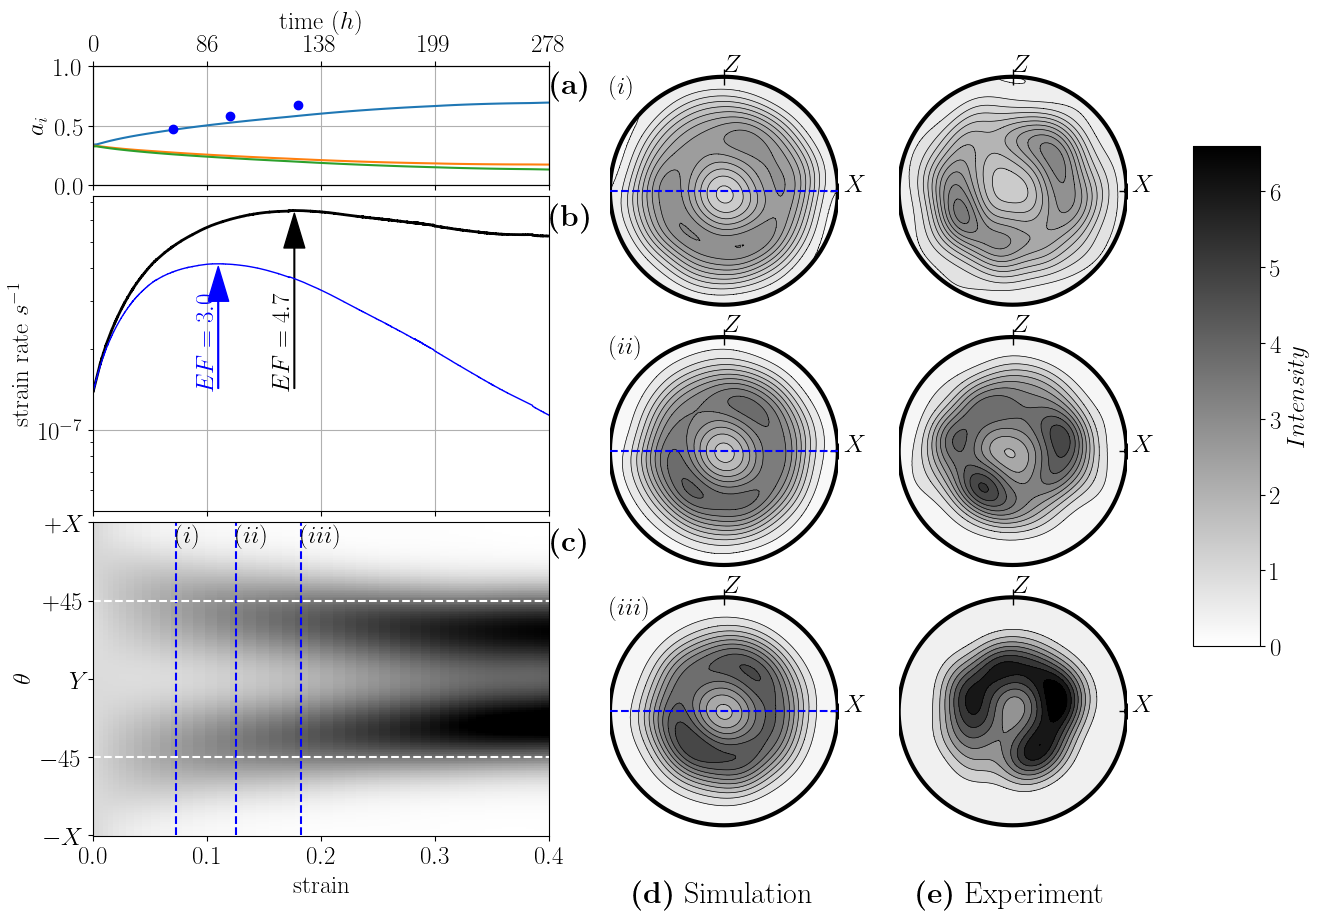

In [3]:
adr_aita=[
    'data_laboratory/Montagnat2015/GI04_AD_aita.dat',
    'data_laboratory/Montagnat2015/GI08_AD_aita.dat',
    'data_laboratory/Montagnat2015/GI10_AD_aita.dat'
]
folder = '../simulation_hexa/Montagnat2015/'
fig_compression=summary_simu(folder,[0.07,0.12,0.18],7.5**3,adr_aita=adr_aita,vmin=0.0,vmax=6.6,plt_cm=True,max_strain=0.4)

## Uniaxial tension

100%|██████████| 56/56 [00:10<00:00,  5.42it/s]


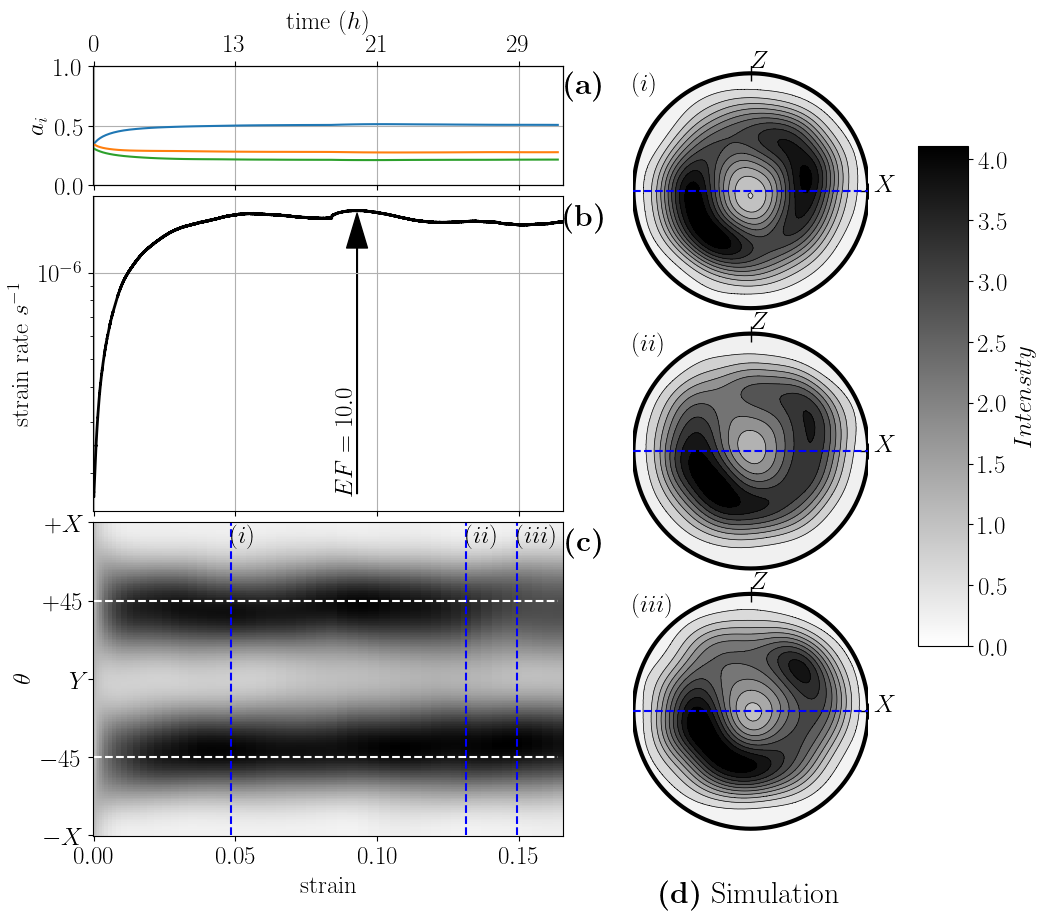

In [4]:
folder = '../simulation_hexa/Jacka1984_1000_1.86e-2/'
fig_tension=summary_simu(folder,[0.05,0.13,0.15],7.5**3,tension=True,vmin=0)

In [5]:
def hist_norm_height(n,bins,const):
    ''' Function to normalise bin height by a constant. 
        Needs n and bins from np.histogram or ax.hist.'''

    n = np.repeat(n,2)
    n = np.float32(n) / const
    new_bins = [bins[0]]
    new_bins.extend(np.repeat(bins[1:],2))
    return n,new_bins[:-1]

[Text(0, 0.0, '$0$'),
 Text(0, 25.0, '$2.5$'),
 Text(0, 50.0, '$5$'),
 Text(0, 75.0, '$7.5$'),
 Text(0, 100.0, '$10$'),
 Text(0, 125.0, '$12.5$'),
 Text(0, 150.0, '$15$'),
 Text(0, 175.0, '$17.5$')]

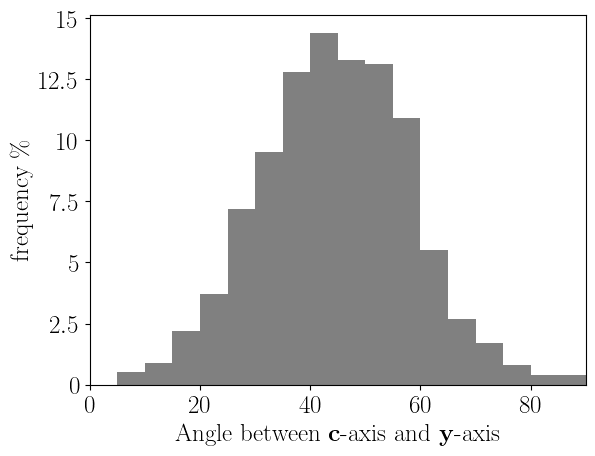

In [6]:
angle=np.arccos(np.abs(fig_tension[2][1].uvecs.xyz()[...,1]))*180/np.pi
fig, ax1 = plt.subplots()
ax1.hist(np.array(angle).flatten(),18,range=[0,90],color='gray')
plt.xlim([0,90])
plt.xlabel(r'$\textrm{Angle between \textbf{c}-axis and \textbf{y}-axis}$')
plt.ylabel(r'$\textrm{frequency }\%$')
y_vals = ax1.get_yticks()
ax1.set_yticklabels([r'$0$',r'$2.5$',r'$5$',r'$7.5$',r'$10$',r'$12.5$',r'$15$',r'$17.5$'])


In [7]:
y_vals/1000

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175])

## Uniaxial shear $\Gamma_{RX}=12~days$

100%|██████████| 149/149 [01:07<00:00,  2.22it/s]


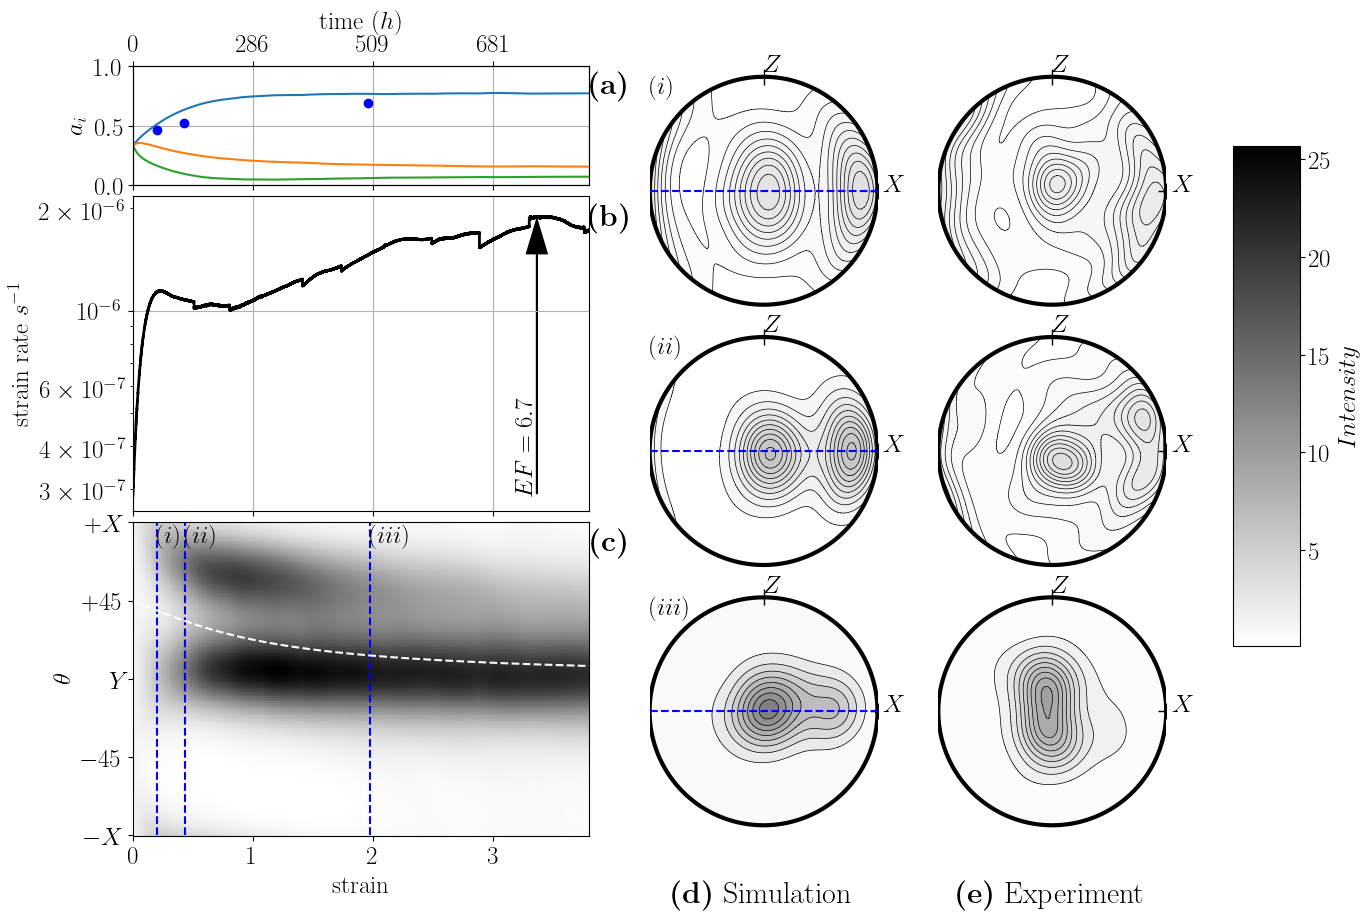

In [8]:
adr_aita=[
    'data_laboratory/Journaux2019/TGI03.dat',
    'data_laboratory/Journaux2019/TGI11.dat',
    'data_laboratory/Journaux2019/TGI12.dat'
]
folder = '../simulation_hexa/Journaux2019/'
fig_shear=summary_simu(folder,[0.2,0.43,1.96],7.5**3,adr_aita=adr_aita,max_strain=3.8)

## No RX

100%|██████████| 482/482 [01:33<00:00,  5.18it/s]


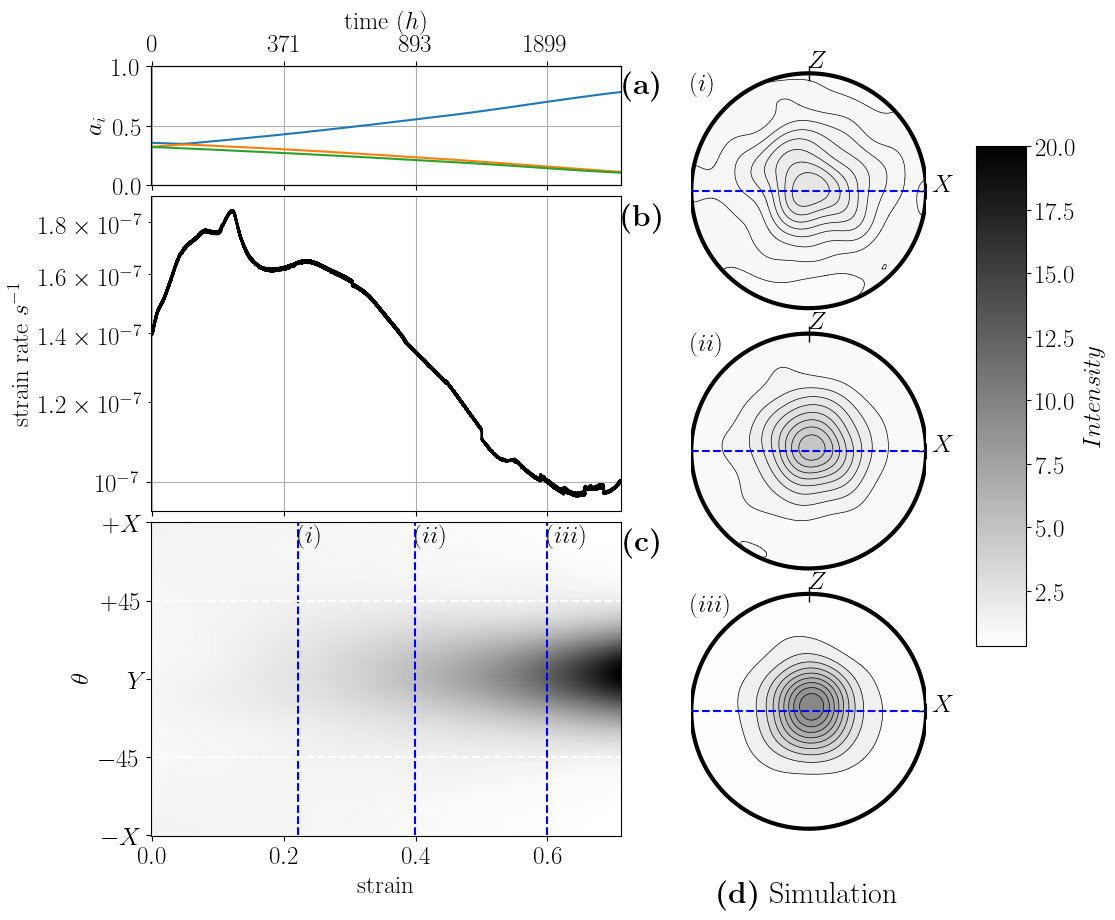

In [9]:
folder = '../simulation_hexa/No_RX_1000_fast/'
fig_tension,df_ai,caxis_plotted=summary_simu(folder,[0.22,0.4,0.60],7.5**3,plotEF=False)

In [10]:
fig_tension.axes[3].plot([0.22,0.4,0.6],[0.51,0.65,0.77],'or')

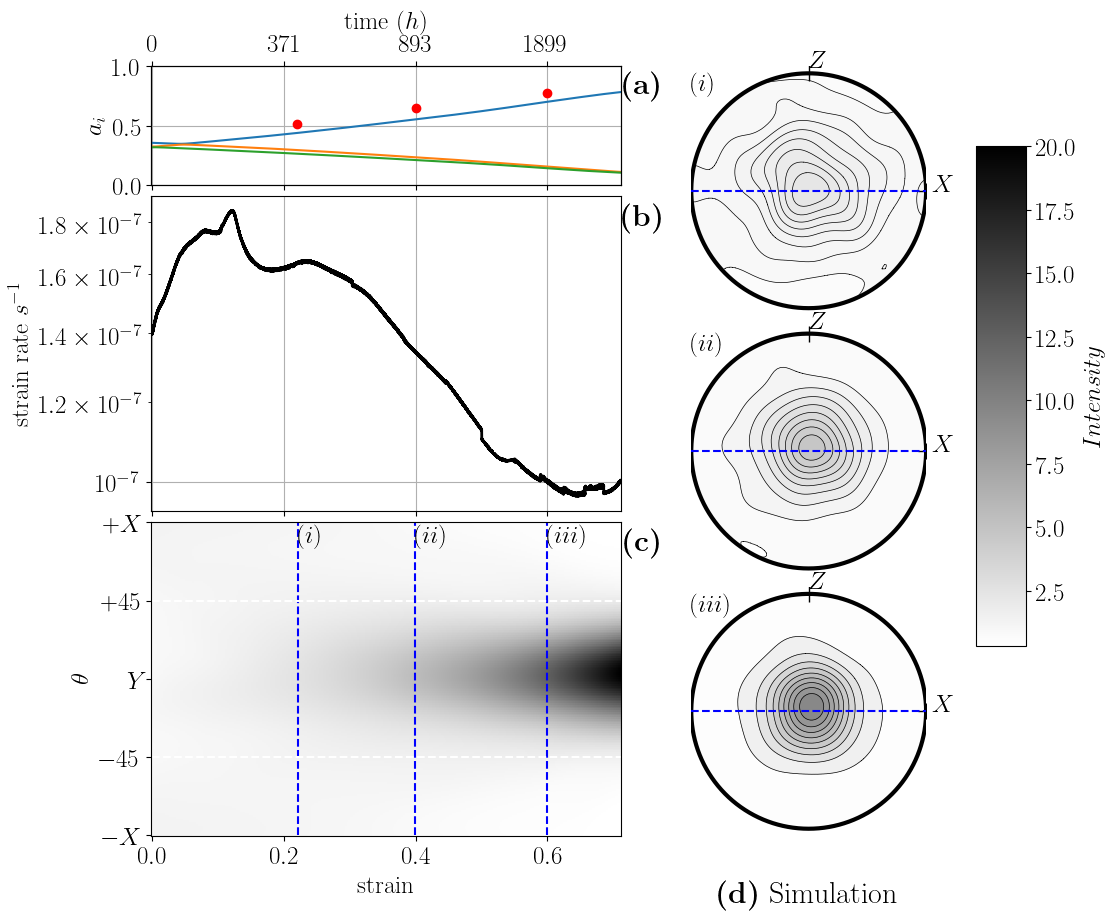

In [11]:
fig_tension

## Solving DDRX equation

$$\Gamma_{RX}\frac{\partial c}{\partial t}+c=c_0 $$

$$ c(t)=(c(0)-c_0)e^{-\frac{t}{\Gamma_{RX}}}+c_0 $$

[Text(0, -0.2, '-1'),
 Text(0, 0.0, '$c(0)$'),
 Text(0, 0.2, '$0.2$'),
 Text(0, 0.4000000000000001, '$0.4$'),
 Text(0, 0.6000000000000001, '$0.6$'),
 Text(0, 0.8, '$0.8$'),
 Text(0, 1.0000000000000002, '$c_0$'),
 Text(0, 1.2000000000000002, '')]

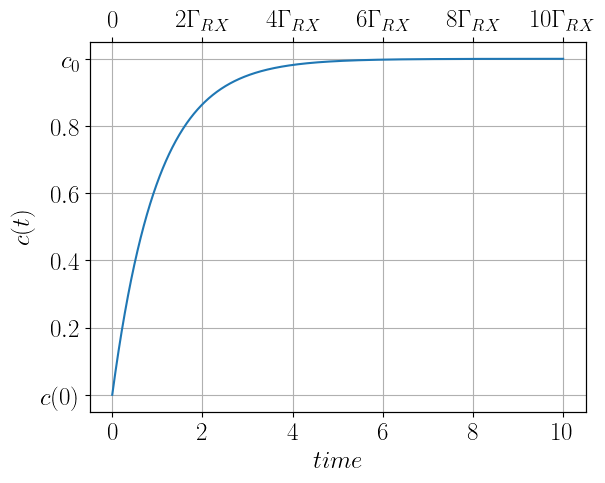

In [12]:
c0=1
ci=0
GRX=1

t=np.linspace(0,10,1000)

plt.figure()
ax=plt.subplot()
plt.plot(t,(ci-c0)*np.exp(-t/GRX)+c0)
plt.grid()
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(['-1','$0$','$2 \Gamma_{RX}$','$4 \Gamma_{RX}$','$6 \Gamma_{RX}$','$8 \Gamma_{RX}$','$10 \Gamma_{RX}$'])
ax.set_xlabel('$time$')
ax.set_ylabel('$c(t)$')
ax.set_yticklabels(['-1','$c(0)$','$0.2$','$0.4$','$0.6$','$0.8$','$c_0$'])

## Qi et al. 2017
### None confined

100%|██████████| 78/78 [00:35<00:00,  2.17it/s]


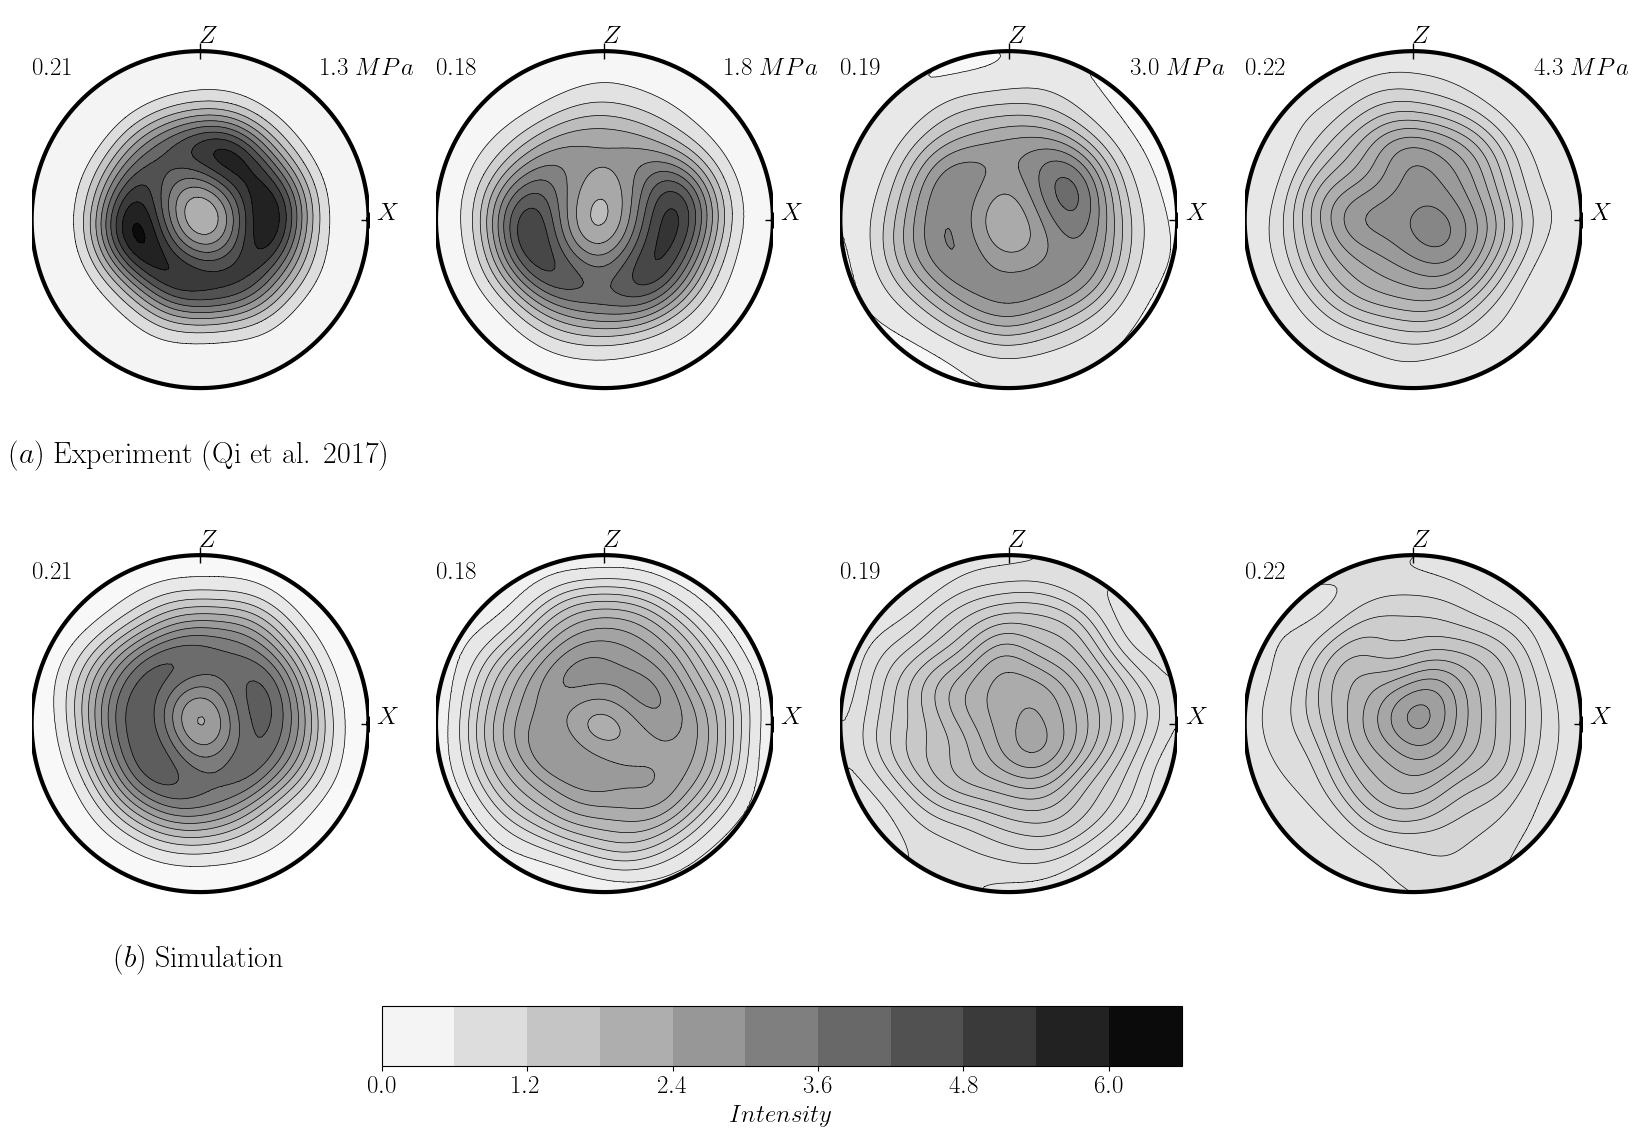

In [4]:
adr_aita=[
    'data_laboratory/Qi2017/PIL032 axial whole clean.ctf',
    'data_laboratory/Qi2017/PIL007 tan whole clean.ctf',
    'data_laboratory/Qi2017/PIL036 axial whole clean.ctf',
    'data_laboratory/Qi2017/PIL033 axial whole clean.ctf'
]
adr_simu=[
    '../simulation_hexa/Qi2017/1.3MPa/',
    '../simulation_hexa/Qi2017/1.8MPa/',
    '../simulation_hexa/Qi2017/3.0MPa/',
    '../simulation_hexa/Qi2017/4.3MPa/',
]
adr_simu=[
    '../simulation_hexa/Qi2017_fast/1.3MPa/',
    '../simulation_hexa/Qi2017_fast/1.8MPa/',
    '../simulation_hexa/Qi2017_fast/3.0MPa/',
    '../simulation_hexa/Qi2017_fast/4.3MPa/',
]


mstrain_aita=[0.21,0.18,0.19,0.22]
mstress=[r'$1.3~MPa$',r'$1.8~MPa$',r'$3.0~MPa$',r'$4.3~MPa$']

fig=plt.figure(figsize=(20,12))
all_df=[]
for i in range(4):
        folder = adr_simu[i]

        with open(folder+'/'+'metadata.json', "r") as read_file:
                data = json.load(read_file)

        ############################
        ###### Load the data #######
        ############################
        current_dir=os.getcwd()
        os.chdir(current_dir+'/'+folder)
        ########## c-axis ##########
        c_axis=lcum.load_vector_P0('c-axis',mod=0)
        os.chdir(current_dir)
        ###### open time_step ######
        df_macro = pd.read_csv(folder+'time_step.txt',delimiter=';')
        df_macro['macro_strain']=np.abs(1-np.cumprod(1.+np.array(df_macro['d22'])*data['time_step']['dt']))

        df=cut_z(c_axis)
        df['iter']=np.concatenate([np.array([0]),np.array(df_macro['macro_strain'][df.iter[1::]*data['output']['out_modulo']-1])])

        idx=np.argmin(np.array(np.abs(df.iter-mstrain_aita[i])))

        plt.subplot(2,4,4+i+1)
        c_axis[idx,...].uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=6.6,cmap=cm.gray_r,plot_cm=False,xoz_plane=True)
        plt.annotate("$"+str(np.round(np.array(df['iter'][idx]),2))+"$",(-2**.5,2**.5-0.2), fontsize=18)
        if i ==0:
                plt.title(r"$(b)~\textrm{Simulation}$", loc="center",y=-0.1)

        all_df.append(df)

        data=lda.load_ctf(adr_aita[i])
        data.aita.filter(75)
        plt.subplot(2,4,i+1)
        _,ff_cbar=data.orientation.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=6.6,cmap=cm.gray_r,plot_cm=False,xoz_plane=True)
        plt.annotate("$"+str(np.round(mstrain_aita[i],2))+"$",(-2**.5,2**.5-0.2), fontsize=18)
        plt.annotate(mstress[i],(2**.5-0.4,2**.5-0.2), fontsize=18)

        if i==0:
                plt.title(r"$(a)~\textrm{Experiment (Qi et al. 2017)}$", loc="center", y=-0.1)
        if i == 0:
                cax = fig.add_axes([0.3, 0, 0.4, 0.05])
                cbar = plt.colorbar(ff_cbar, cax=cax, orientation='horizontal')
                cbar.set_label('$Intensity$')